In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import joblib
import numpy as np

# --- 1. Robustly Load and Flatten Data to a "Long" Format ---
try:
    with open('mongodb_export_cleaned.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    print("Successfully loaded data as a single JSON array.")
except json.JSONDecodeError:
    print("Could not load as a single array. Retrying as line-delimited JSON (NDJSON)...")
    data = []
    try:
        with open('mongodb_export_cleaned.json', 'r', encoding='utf-8') as f:
            for line in f:
                stripped_line = line.strip()
                if stripped_line:
                    data.append(json.loads(stripped_line))
        print("Successfully loaded data as line-delimited JSON.")
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"FATAL ERROR: Could not load or parse 'mongodb_export_cleaned.json'.")
        print(f"Error details: {e}")
        exit()

# Flatten the data from 'sorted_windows' into a list of dictionaries
all_windows = []
for session in data:
    session_id = session.get('_id')
    exercise_type = session.get('session_metadata', {}).get('exercise_type')
    
    node_id_to_name = {
        info['node_id']: info['node_name']
        for mac, info in session.get('session_metadata', {}).get('devices', {}).items()
    }
    
    for window in session.get('sorted_windows', []):
        if 'features' in window and window.get('window_type') == 'short':
            feature_dict = window['features'].copy()
            # Add identifying information to each window's feature set
            feature_dict['session_id'] = session_id
            feature_dict['exercise_type'] = exercise_type
            # Also add window start time to uniquely identify a time slice
            feature_dict['window_start_ms'] = window.get('window_start_ms')
            node_id = window.get('node_id')
            device_name = node_id_to_name.get(node_id, f"unknown_node_{node_id}")
            feature_dict['device_id'] = device_name
            all_windows.append(feature_dict)

# Create the initial "long" format DataFrame
df_long = pd.DataFrame(all_windows)
print(f"\nLoaded {len(df_long)} total sensor windows.")


# --- 2. Pivot Data to "Wide" Format (Combine Sensors) ---
print("Pivoting data to combine sensors into a single row per time window...")

# Define the columns that identify a unique window in time
index_cols = ['session_id', 'exercise_type', 'window_start_ms']
# Identify feature columns to be pivoted
feature_cols = [col for col in df_long.columns if col not in index_cols + ['device_id', 'processing_timestamp']]

# Use pivot_table to transform the data from long to wide format
# Each row will be a unique time window, columns will be features from each device
df_wide = df_long.pivot_table(
    index=index_cols,
    columns='device_id',
    values=feature_cols
)

# Flatten the multi-level column index (e.g., from ('qx_mean', 'CHEST') to 'qx_mean_CHEST')
df_wide.columns = ['_'.join(str(c) for c in col).strip() for col in df_wide.columns.values]

# The index now contains our identifying columns. Let's make them regular columns again.
df_wide.reset_index(inplace=True)

# --- Verification Step: Inspect Columns ---
print("\n--- Verifying Sensor Columns ---")
expected_sensors = ['THIGH', 'CHEST', 'WRIST', 'BICEP']
actual_columns = df_wide.columns.tolist()  # <-- Use df_wide here

# Check which sensors are present in the column names
sensors_found = set()
for col in actual_columns:
    for sensor in expected_sensors:
        if f'_{sensor}' in col:
            sensors_found.add(sensor)

print(f"Sensors found in DataFrame columns: {sorted(list(sensors_found))}")

# Alert if any sensors are missing
missing_sensors = set(expected_sensors) - sensors_found
if missing_sensors:
    print(f"WARNING: The following sensors are missing from the data: {missing_sensors}")
else:
    print("All expected sensors (THIGH, CHEST, WRIST, BICEP) are present.")

# You can also print a few column names to see the structure
print("\nExample column names:")
print(actual_columns[:5])
print("...")
print(actual_columns[-5:])
print("--- End of Verification ---\n")


# --- Verification Step: Check for Missing Data Before Fill ---
print("\n--- Checking for Missing Sensor Data (before filling NaNs) ---")

# Create a temporary copy to inspect before filling NaNs
df_pre_fill = df_wide.copy()

# Identify columns related to each sensor
thigh_cols = [col for col in df_pre_fill.columns if '_THIGH' in col]
chest_cols = [col for col in df_pre_fill.columns if '_CHEST' in col]
wrist_cols = [col for col in df_pre_fill.columns if '_WRIST' in col]
bicep_cols = [col for col in df_pre_fill.columns if '_BICEP' in col]

# Check how many rows (time windows) have at least one NaN for each sensor
print(f"Windows with any missing THIGH data: {df_pre_fill[thigh_cols].isnull().any(axis=1).sum()}")
print(f"Windows with any missing CHEST data: {df_pre_fill[chest_cols].isnull().any(axis=1).sum()}")
print(f"Windows with any missing WRIST data: {df_pre_fill[wrist_cols].isnull().any(axis=1).sum()}")
print(f"Windows with any missing BICEP data: {df_pre_fill[bicep_cols].isnull().any(axis=1).sum()}")
print("--- End of Missing Data Check ---\n")

# Now, you can fill the NaNs as before
# The pivot can create NaNs if a sensor missed a window. Fill them with 0.
df_wide.fillna(0, inplace=True)

# Overwrite the main df with our new, powerful wide-format DataFrame
df = df_wide.copy()

print(f"Pivoted data into {len(df)} time windows with {len(df.columns)} feature columns.")


# --- 3. Group-Based Data Splitting (NO DATA LEAKAGE) ---
print("\nPerforming group-based split to prevent data leakage...")

# Create a DataFrame of unique sessions to perform the split
session_df = df[['session_id', 'exercise_type']].drop_duplicates()

# Split the unique sessions, stratifying by exercise type
train_session_ids, test_session_ids = train_test_split(
    session_df['session_id'],
    test_size=0.25,
    random_state=42,
    stratify=session_df['exercise_type']
)

# Create the training and testing sets by filtering the main DataFrame
train_df = df[df['session_id'].isin(train_session_ids)].copy()
test_df = df[df['session_id'].isin(test_session_ids)].copy()

print(f"Total sessions: {len(session_df)}")
print(f"Training sessions: {len(train_session_ids)}")
print(f"Testing sessions: {len(test_session_ids)}")
print(f"Training time windows: {len(train_df)}")
print(f"Testing time windows: {len(test_df)}")


# --- 4. Feature Preparation ---
# Define identifier columns to be dropped from the feature set
# 'device_id' is no longer a column, so it's not here
id_cols_to_drop = ['session_id', 'exercise_type', 'window_start_ms']

# Prepare training data
X_train = train_df.drop(columns=id_cols_to_drop, errors='ignore')
y_train_labels = train_df['exercise_type']

# Prepare testing data
X_test = test_df.drop(columns=id_cols_to_drop, errors='ignore')
y_test_labels = test_df['exercise_type']

# Align columns - still important in case a sensor/device was only present in train or test
train_cols, test_cols = X_train.columns, X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train[c] = 0
X_test = X_test[X_train.columns]

# Encode the target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# --- 5. Train the Model ---
print("\n--- Training the XGBoost Model ---")
model = XGBClassifier(colsample_bytree=0.8, learning_rate=np.float64(0.2), max_depth=10, n_estimators=300, n_jobs=-1, num_class=4)
model.fit(X_train, y_train)
print("Model training completed.")

# --- 6. Evaluate the Model ---
print("\n--- Evaluating the Model on Test Set ---")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# --- 7. Finalizing and Saving Model ---
print("\n--- Finalizing and Saving Model ---")
joblib.dump(model, 'exercise_classifier_model.joblib')
joblib.dump(le, 'label_encoder.joblib')
print("Model saved successfully to: exercise_classifier_model.joblib")
print("Label encoder saved successfully to: label_encoder.joblib")

# --- 7. Save Feature Names for Exercise Classifier ---
print("\n--- Saving Exercise Classifier Feature Names ---")
joblib.dump(X_train.columns.tolist(), 'exercise_classifier_features.joblib')
print("✓ Exercise classifier features saved to: exercise_classifier_features.joblib")

: 


--- Evaluating the Model on the Hold-Out Test Set ---
Accuracy on test set: 91.14%

Classification Report (Precision, Recall, F1-Score per Class):
              precision    recall  f1-score   support

 BENCH_PRESS       0.94      0.89      0.91       277
  BICEP_CURL       0.96      0.91      0.93       561
     PULL_UP       0.86      0.84      0.85       239
       SQUAT       0.86      0.98      0.92       357

    accuracy                           0.91      1434
   macro avg       0.90      0.90      0.90      1434
weighted avg       0.91      0.91      0.91      1434


Confusion Matrix:


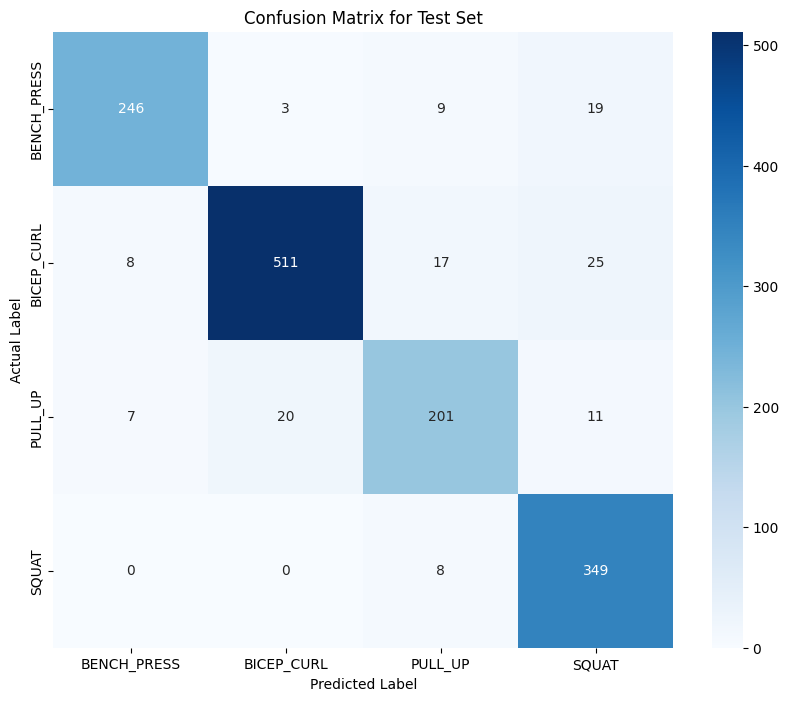

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 6. Evaluate the Model on the Hold-Out Test Set ---
print("\n--- Evaluating the Model on the Hold-Out Test Set ---")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# Generate and print a detailed classification report
print("\nClassification Report (Precision, Recall, F1-Score per Class):")
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

# Generate and plot a confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()